# Zindi Challenge for Predicting the Burned Area of Wildfires in Zimbabwe


## 1.0 Introduction
Each year, thousands of fires blaze across the African continent. Some of the fires occur naturally while others are man-made. But whatever the cause, these fires result in massive damage, such as the loss of lives and property and air pollution through smoke and carbon dioxide emission.

[The occurence, rage, and spread of a wildfire is influenced by various factors](https://www.gov.nt.ca/ecc/en/services/wildfire-operations/wildfire-science) such as the quantity and dryness of vegetation and wood, humidity, precipitation, solar radiation, temperature, wind, land elevation, and so on.

To better understand the dynamics that influence the magnitude of these fires across Zimbabwe, Zindi has hosted a competition for predicting the burned area in different square locations throughout Zimbabwe over 2014 to 2017.

### 1.1 Problem Statement
From history, wildfires have caused devastating damage and therefore, there is a need to predict where and when they will occur in future across Zimbabwe.
### 1.2 Project Objective
To determine the monthly percentage of burned area in specific square areas across Zimbabwe, over the years 2014 to 2017.

### 1.3 Perfomance Evaluation
The evaluation metric for this competition is [Root Mean Squared Error](https://zindi.africa/learn/zindi-error-metric-series-what-is-root-mean-square-error-rmse).

We need to predict the proportion of the burned area per square area, with values ranging from 0 to 1.

## 2.0 Data Description
Zindi has aggregated data about the percentage of burned areas across Zimbabwe for each month from January 2001 to December 2013.
The data has the following features:
1. **ID**: The IDs take the form of [area ID]_yyyy-mm-dd. There are 533 area squares each with a unique ID ranging from 0 to 532
2. **area**: Area ID
3. **date**: The date that the data is aggregated over
4. **lat**: Latitude of the center of the area
5. **lon**: Longitude of the center of the area
6. **climate_aet**: Actual evapotranspiration, derived using a one-dimensional soil water balance model
7. **climate_def**: Climate water deficit, derived using a one-dimensional soil water balance model
8. **climate_pdsi**: Palmer Drought Severity Index
9. **climate_pet**: Reference evapotranspiration (ASCE Penman-Montieth)
10. **climate_pr**: Precipitation accumulation
11. **climate_ro**: Runoff, derived using a one-dimensional soil water balance model
12.**climate_soil**: Soil moisture, derived using a one-dimensional soil water balance model
13. **climate_srad**: Downward surface shortwave radiation
14. **climate_swe**: Snow water equivalent, derived using a one-dimensional soil water balance model
15. **climate_tmmn**: Minimum temperature
16. **climate_tmmx**: Maximum temperature
17. **climate_vap**: Vapor pressure
18. **climate_vpd**: Vapor pressure deficit
19. **climate_vs**: Wind-speed at 10m
20. **elevation**: Land elevation
21. **landcover_0**: Water Bodies: at least 60% of area is covered by permanent water bodies
22. **landcover_1**: Evergreen Needleleaf Vegetation: dominated by evergreen conifer trees and shrubs (>1m). Woody vegetation cover >10%.
23. **landcover_2**: Evergreen Broadleaf Vegetation: dominated by evergreen broadleaf and palmate trees and shrubs (>1m). Woody vegetation cover >10%.
24. **landcover_3**: Deciduous Needleleaf Vegetation: dominated by deciduous needleleaf (larch) trees and shrubs (>1m). Woody vegetation cover >10%.
25. **landcover_4**: Deciduous Broadleaf Vegetation: dominated by deciduous broadleaf trees and shrubs (>1m). Woody vegetation cover >10%.
26. **landcover_5**: Annual Broadleaf Vegetation: dominated by herbaceous annuals (<2m). At least 60% cultivated broadleaf crops.
27. **landcover_6**: Annual Grass Vegetation: dominated by herbaceous annuals (<2m) including cereal croplands.
28. **landcover_7**: Non-Vegetated Lands: at least 60% of area is non-vegetated barren (sand, rock, soil) or permanent snow/ice with less than 10% vegetation.
29. **landcover_8**: Urban and Built-up Lands: at least 30% impervious surface area including building materials, asphalt, and vehicles.
30. **precipitation**: Merged microwave/IR precipitation estimate

The data is in three files:
1. Train.csv for training machine learning models.
2. Test.csv for creating predictions of burned area and test the performance of models. It contains all the columns in the train data except the burn_area column.
3. variable_definitions.csv that contains the definitions of all variables involved.


## 3.0 Setup and Data Understanding

I first uploaded the three data files to a Google Drive subfolder named Competitions which is in a folder named Data_Sc_Software_Eng.
I then installed and imported the necessary Python modules.

In [1]:
# !pip install pmdarima

In [2]:
# !pip install pykalman

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pykalman import KalmanFilter
import joblib

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('../data/Train.csv')
test = pd.read_csv('../data/Test.csv')
sub = pd.read_csv('../data/SampleSubmission.csv')

In [5]:
# Observe the data types in train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83148 entries, 0 to 83147
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             83148 non-null  object 
 1   lat            83148 non-null  float64
 2   lon            83148 non-null  float64
 3   burn_area      83148 non-null  float64
 4   climate_aet    83148 non-null  int64  
 5   climate_def    83148 non-null  int64  
 6   climate_pdsi   83148 non-null  int64  
 7   climate_pet    83148 non-null  int64  
 8   climate_pr     83148 non-null  int64  
 9   climate_ro     83148 non-null  int64  
 10  climate_soil   83148 non-null  int64  
 11  climate_srad   83148 non-null  int64  
 12  climate_swe    83148 non-null  int64  
 13  climate_tmmn   83148 non-null  int64  
 14  climate_tmmx   83148 non-null  int64  
 15  climate_vap    83148 non-null  int64  
 16  climate_vpd    83148 non-null  int64  
 17  climate_vs     83148 non-null  int64  
 18  elevat

In [6]:
# View the first 5 rows of training data.
train.head()

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2001-01-01,-15.858835,29.237029,0.0,1195,0,263,1195,206,10,...,0.0,0.0,0.018654,0.0,0.714446,0.012174,0.244890,0.009836,0.0,0.256932
1,1_2001-01-01,-15.858835,29.487029,0.0,1196,0,232,1196,201,10,...,0.0,0.0,0.000000,0.0,0.654783,0.000095,0.345121,0.000000,0.0,0.273093
2,2_2001-01-01,-15.858835,29.737029,0.0,1190,0,314,1190,192,10,...,0.0,0.0,0.000000,0.0,0.516421,0.000000,0.483579,0.000000,0.0,0.285109
3,3_2001-01-01,-15.858835,29.987029,0.0,1144,0,321,1144,186,66,...,0.0,0.0,0.000000,0.0,0.299000,0.163902,0.537098,0.000000,0.0,0.298418
4,4_2001-01-01,-15.858835,30.237029,0.0,1187,0,413,1187,186,9,...,0.0,0.0,0.000000,0.0,0.277392,0.067742,0.654866,0.000000,0.0,0.315621


In [7]:
# The test set - notice there is no 'burn_area' column.
test.head(1)

,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2014-01-01,-15.858835,29.237029,1146,74,-451,1220,120,6,212,...,0.0,0.000615,0.015418,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243


## 4.0 EDA + Feature Engineering

In [8]:
# Look at distribution of each variable
train.describe()

,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
count,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,...,83148.000000,83148.000000,83148.000000,8.314800e+04,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000
mean,-19.014557,29.860856,0.007632,484.491124,828.892721,-30.806237,1313.382992,54.576322,6.215134,305.477919,...,0.006158,0.000017,0.008583,4.066313e-08,0.160628,0.037453,0.785382,0.000354,0.001424,0.078551
std,1.588444,1.751090,0.029226,470.467480,546.934469,235.802930,315.209838,71.997561,21.480399,400.956123,...,0.053111,0.000141,0.059046,3.535121e-06,0.192957,0.106050,0.233953,0.001773,0.014233,0.104464
min,-22.358835,25.487029,0.000000,0.000000,0.000000,-563.000000,587.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000
25%,-20.358835,28.487029,0.000000,50.000000,375.000000,-212.000000,1081.000000,1.000000,0.000000,70.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.014993,0.000000,0.655322,0.000000,0.000000,0.002017
50%,-18.858835,29.987029,0.000000,302.000000,858.000000,-108.000000,1290.000000,22.000000,1.000000,149.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.076706,0.000139,0.880600,0.000000,0.000000,0.028503
75%,-17.858835,31.237029,0.000000,931.000000,1211.000000,142.000000,1517.000000,87.000000,4.000000,329.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.246498,0.015166,0.971209,0.000000,0.000000,0.125500
max,-15.858835,32.987029,0.843886,1713.000000,2614.000000,851.000000,2620.000000,501.000000,342.000000,3319.000000,...,0.828131,0.004918,0.711603,3.073689e-04,0.981472,0.881323,1.000000,0.016708,0.301823,0.801328


We observe that the highest recorded percentage of burned area is about 84.39%. The lowest percentage is 0%.

The 25th, 50th, and 75th percetiles are all 0%, which indicates that majority of the areas did not experience wild fires.

In [9]:
# Inspect whether there are columns with missing values
train.isna().sum()

ID               0
lat              0
lon              0
burn_area        0
climate_aet      0
climate_def      0
climate_pdsi     0
climate_pet      0
climate_pr       0
climate_ro       0
climate_soil     0
climate_srad     0
climate_swe      0
climate_tmmn     0
climate_tmmx     0
climate_vap      0
climate_vpd      0
climate_vs       0
elevation        0
landcover_0      0
landcover_1      0
landcover_2      0
landcover_3      0
landcover_4      0
landcover_5      0
landcover_6      0
landcover_7      0
landcover_8      0
precipitation    0
dtype: int64

In [10]:
# Check for duplicates
train.duplicated().sum()

0

climate_vap     -0.221348
climate_aet     -0.211806
climate_pr      -0.170532
precipitation   -0.169218
climate_tmmn    -0.099436
climate_soil    -0.089246
landcover_6     -0.075815
climate_ro      -0.071414
landcover_7     -0.027734
lon             -0.021698
climate_pdsi    -0.014831
landcover_2     -0.008348
landcover_0     -0.008137
landcover_1     -0.007266
landcover_8     -0.005215
landcover_3      0.000964
landcover_4      0.013846
climate_tmmx     0.040500
elevation        0.074576
lat              0.140848
landcover_5      0.151957
climate_srad     0.160517
climate_pet      0.168871
climate_vpd      0.219974
climate_vs       0.261562
climate_def      0.279511
burn_area        1.000000
climate_swe           NaN
Name: burn_area, dtype: float64


<Axes: >

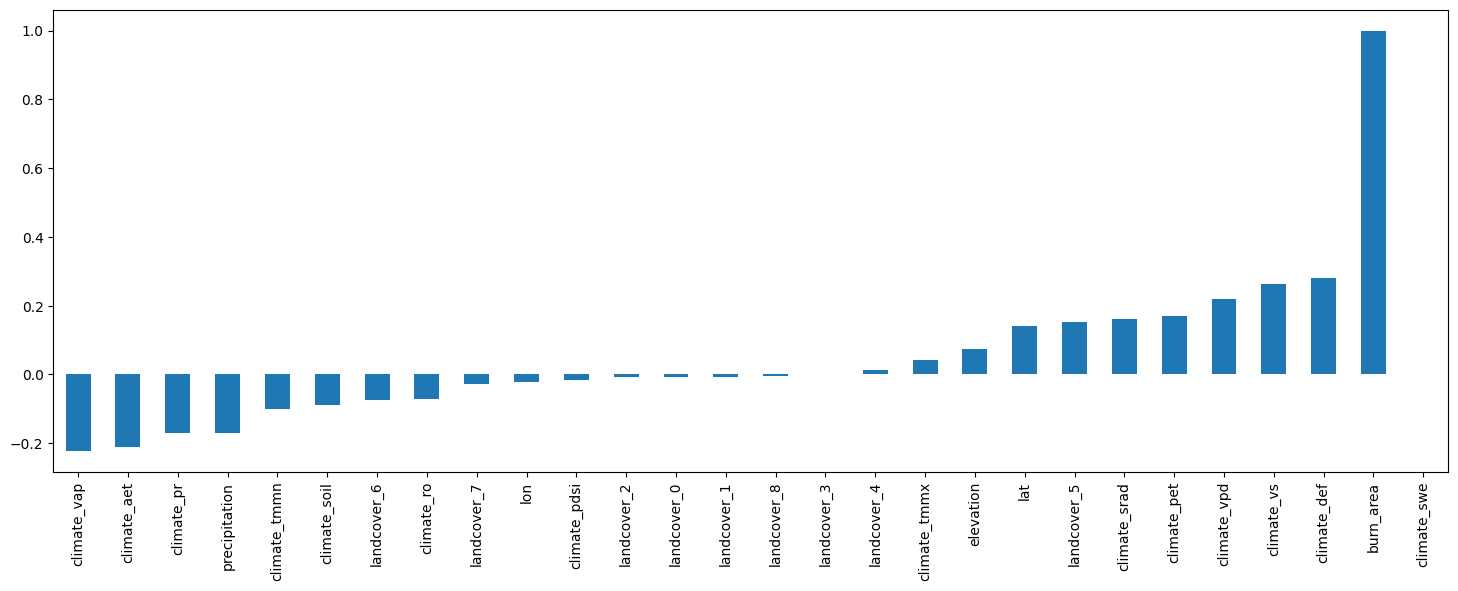

In [11]:
# Look at correlation of all variables with the target (burn_area) variable
# Exclude the inappropriate columns from the original DataFrame
columns_to_exclude = ['ID', 'date', 'month', 'year']
numeric_columns = train.select_dtypes(include=['number']).drop(columns=columns_to_exclude, errors='ignore')

# Calculate the correlation with 'burn_area'
correlation_with_burn_area = numeric_columns.corr()['burn_area']

# Sort the correlation values
sorted_correlation_with_burn_area = correlation_with_burn_area.sort_values()

# Print the sorted correlation values
print(sorted_correlation_with_burn_area)

# Plot the correlations
train.select_dtypes(include=['number']).corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

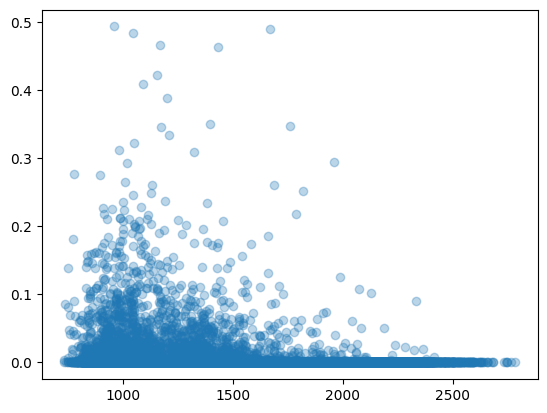

In [12]:
# Look at some scatter plots (only plotting for a subset of data to keep things fast)
sample = train.sample(10000)
plt.scatter(sample['climate_vap'], sample['burn_area'], alpha=0.3)

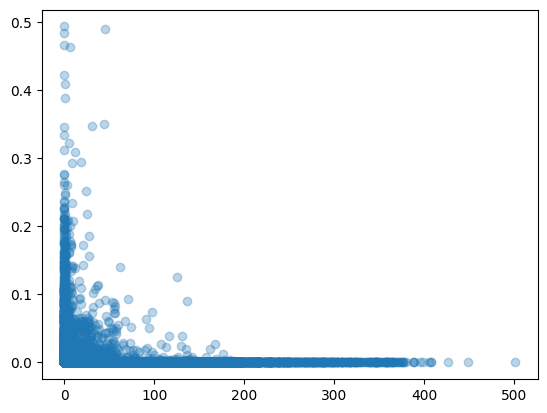

In [13]:
# Most fires occur when there's very little rain.
plt.scatter(sample['climate_pr'], sample['burn_area'], alpha=0.3)

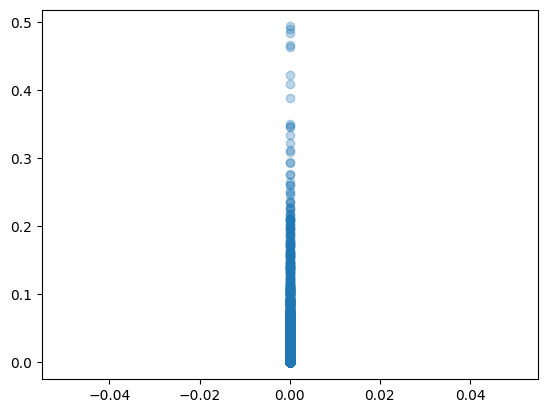

In [14]:
# There is no snowing in Zimbabwe
plt.scatter(sample['climate_swe'], sample['burn_area'], alpha=0.3)

### 4.1 Adding date features

In [15]:
# Split the ID (eg 127_2017-01-03) to get the date string, which we convert to datetime to make life easier
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
test['date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[1]))

In [16]:
# Add month and year date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

In [17]:
# Group by month and calculate the mean burn_area
monthly_mean_burn_area = train.groupby('month')['burn_area'].mean().reset_index()

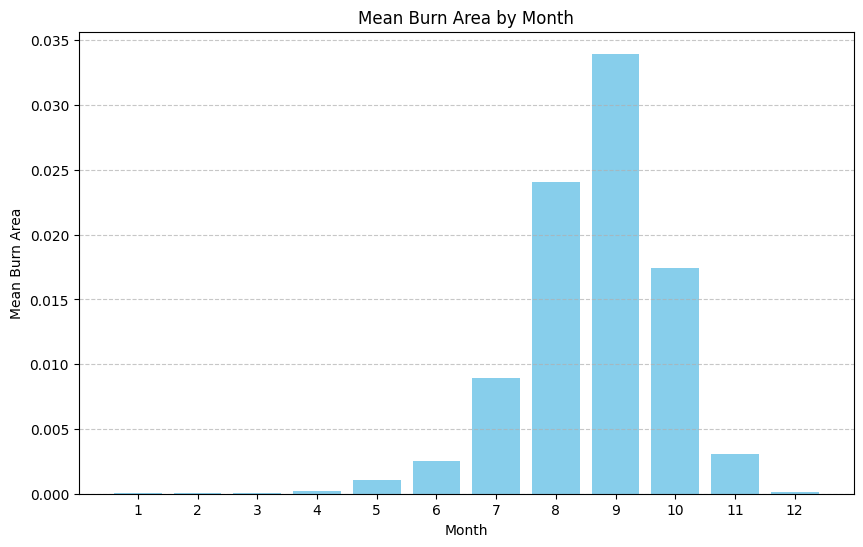

In [18]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(monthly_mean_burn_area['month'], monthly_mean_burn_area['burn_area'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Mean Burn Area')
plt.title('Mean Burn Area by Month')
plt.xticks(monthly_mean_burn_area['month'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We can observe that the strongest fires tend to occur from the months of July to October.

In [19]:
# Group by year and calculate the mean burn_area
yearly_mean_burn_area = train.groupby('year')['burn_area'].mean().reset_index()

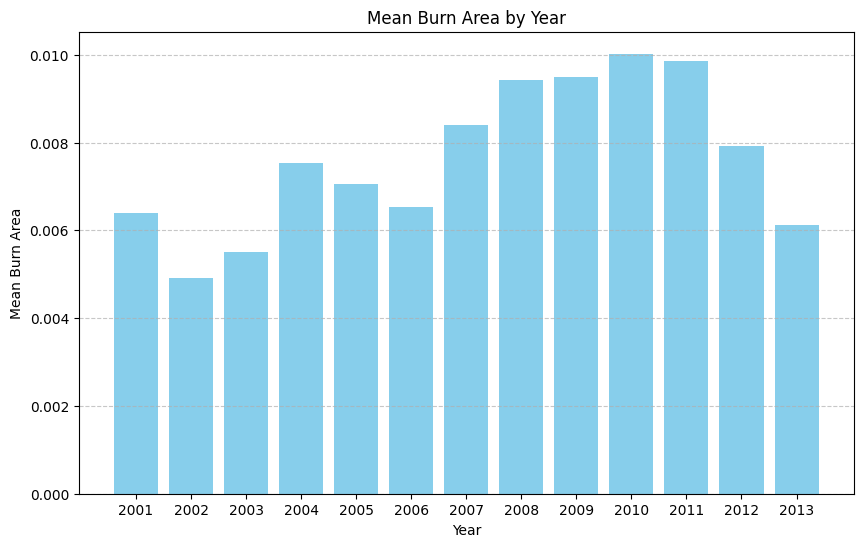

In [20]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(yearly_mean_burn_area['year'], yearly_mean_burn_area['burn_area'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Mean Burn Area')
plt.title('Mean Burn Area by Year')
plt.xticks(yearly_mean_burn_area['year'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We can observe that wildfires were more prevalent in certain years than others.

### 4.2 Adding Real ID column

In [21]:
# Split the ID (eg 127_2017-01-03) to get the area ID
train['real_id'] = pd.to_numeric(train['ID'].apply(lambda x: x.split('_')[0]))
test['real_id'] = pd.to_numeric(test['ID'].apply(lambda x: x.split('_')[0]))

### 4.3 Trend and Seasonality Analysis
We have visually observed the easonality of the burned area.
The country is divided into 533 areas and each area has its own historical data.
We will therefore, convert the data to a time series and split burn_area data into seasonal, underlying trend, and residual components for sample areas.

In [22]:
# Set date column as the index
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

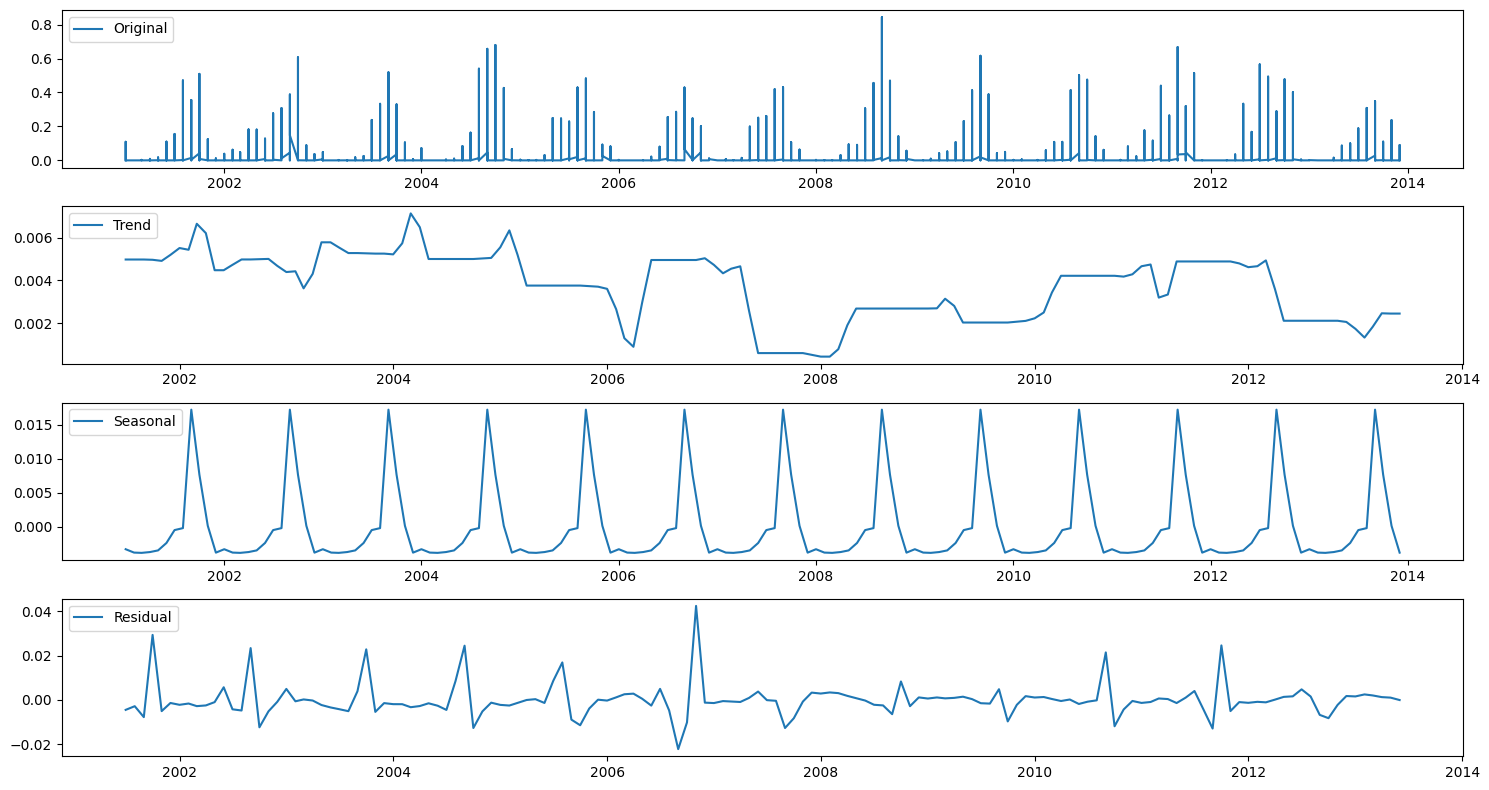

In [23]:
# Time series decomposition of area ID 0
train_0 = train.loc[train.real_id == 0]

decomposition_result = seasonal_decompose(train_0['burn_area'], model='additive', period=12)  # Annual seasonality

# Plot the original time series
plt.figure(figsize=(15, 8))
plt.subplot(4, 1, 1)
plt.plot(train['burn_area'], label='Original')
plt.legend(loc='upper left')

# Plot the trend
plt.subplot(4, 1, 2)
plt.plot(decomposition_result.trend, label='Trend')
plt.legend(loc='upper left')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition_result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Plot the residual or noise
plt.subplot(4, 1, 4)
plt.plot(decomposition_result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

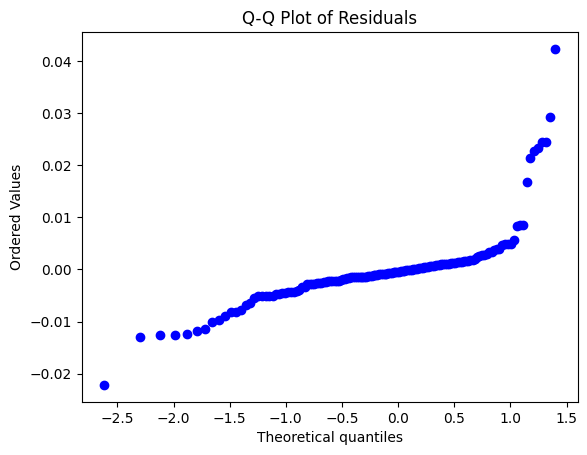

In [24]:
# Plot a Q-Q plot of the residuals to see if they are normally distributed
stats.probplot(decomposition_result.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

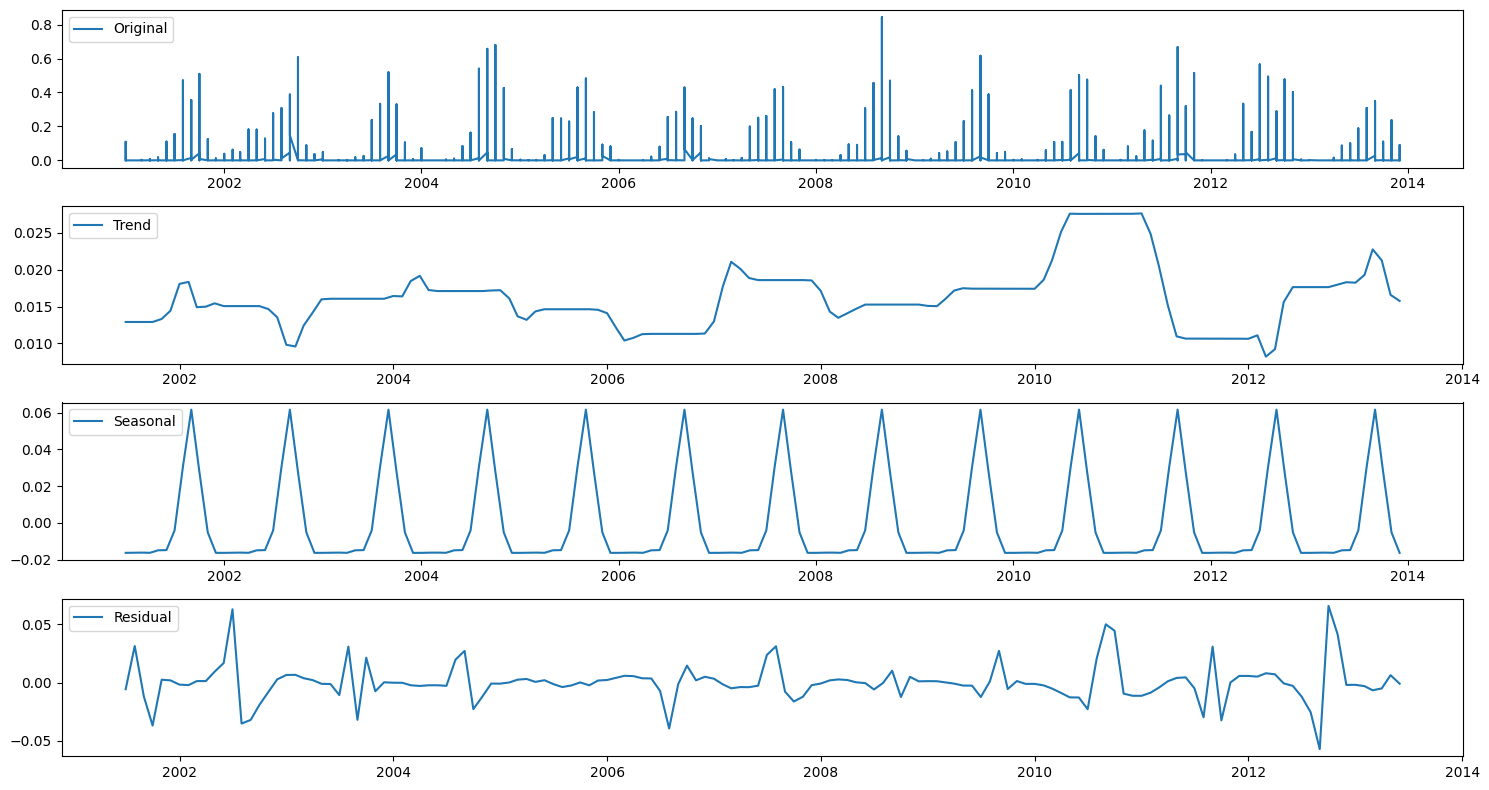

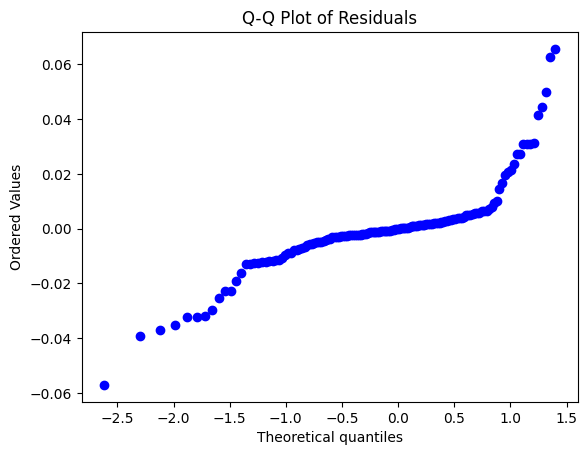

In [25]:
# Time series decomposition of area ID 78
train_78 = train.loc[train.real_id == 78]

decomposition_result = seasonal_decompose(train_78['burn_area'], model='additive', period=12)  # Annual seasonality

# Plot the original time series
plt.figure(figsize=(15, 8))
plt.subplot(4, 1, 1)
plt.plot(train['burn_area'], label='Original')
plt.legend(loc='upper left')

# Plot the trend
plt.subplot(4, 1, 2)
plt.plot(decomposition_result.trend, label='Trend')
plt.legend(loc='upper left')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition_result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Plot the residual or noise
plt.subplot(4, 1, 4)
plt.plot(decomposition_result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Plot a Q-Q plot of the residuals to see if they are normally distributed
stats.probplot(decomposition_result.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

Observations from the time series decomposition:
1. The trend appears relatively stable with small variations.
2. The seasonal component is regular and yearly.
3. The residuals are relatively normally distributed, suggesting that the trend and seasonal components have captured most of the information in the data.

The proportion of random noise or residuals in a time series can significantly influence future outcomes.

High variance of the residuals indicates statistical significance while low variance indicates statistical insignificance.

We will now run an Augmented Dickey-Fuller (ADF) Test to test the null hypothesis that the residuals are not stationary. If the p-value is below 0.05, we will reject the null hypothesis and conclude that the residuals are stationary, meaning that the trend and seasonal components have captured much of the information in the data and the residuals can be ignored.

In [26]:
# Drop NaN values from residuals
clean_residuals = decomposition_result.resid.dropna()

# Run the ADF test on the cleaned residuals
adf_test = adfuller(clean_residuals)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("The residuals are stationary.")
else:
    print("The residuals are not stationary.")

ADF Statistic: -6.011327208858988
p-value: 1.5709161690819873e-07
The residuals are stationary.


## 5.0 Time Series Modelling

### 5.1 Data Split for Validation
To test the performance of different models, we need to split the train data into train and validation sets.

We don't want to just split randomly - this would give us artificially high scores. Instead, let's use the last 3 years of the dataset for validation to more closely match the test configuration.

In [27]:
# Convert date to string and split at 2011-01-01
X_train = train.loc[train.index.strftime('%Y-%m-%d') < '2011-01-01']
y_test = train.loc[train.index.strftime('%Y-%m-%d') >= '2011-01-01']
print(X_train.shape, y_test.shape)

(63960, 32) (19188, 32)


### 5.2 Baseline Models
The country is divided into 533 areas and each area has its own historical data. Therefore, to build a time series model, we will need to filter the data per area, build and test the models in a loop, and finally append the RMSE values to a list.

#### 5.2.1 Simple Auto ARIMA model
Given the seasonal nature of the time series, we will first build a simple Auto ARIMA model with the seasonal parameter set to True.


In [28]:
# Initialize an empty list to store RMSE values for each area
rmse_values = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    # Train Test Split
    X_train_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') < '2011-01-01']
    y_test_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') >= '2011-01-01']

    # Simple model
    baseline_model = auto_arima(X_train_area['burn_area'], seasonal=True)

    # Forecast the same length as the test data
    forecast_length = len(y_test_area)
    predicted_data = baseline_model.predict(n_periods=forecast_length)
    predicted_data = pd.Series(predicted_data, index=y_test_area.index)

    # Calculate RMSE for the current area ID
    rmse_area = np.sqrt(mean_squared_error(y_test_area['burn_area'], predicted_data))
    rmse_values.append(rmse_area)

# Calculate the overall RMSE by averaging the RMSE values of all areas
overall_rmse = np.mean(rmse_values)
print('Overall Test RMSE:', overall_rmse)

Overall Test RMSE: 0.017360797568748237


#### 5.2.2 Tuned Auto ARIMA model

The auto ARIMA model can be tuned to test different combinations of seasonal (P, D, Q) and non-seasonal orders p, d, and q (where p, d, and q represent the autoregressive, differencing, and moving average terms, respectively) and generate the best order combination.

To limit the computation complexity and time, we will set max_order=5, which means that the sum of P, Q, and D or p, q, and d cannot exceed 5.
Augmented Dickey-Fuller test "adf" will be used to determine the optimal differencing term.


NB: From my tests, I realised that some areas such as 270 and 271 have insufficient variability of burned area data, making it impossible for the model to test and determine an appropriate differencing term, d.

In [29]:
# Time Series for area 270
train_270 = train.loc[train.real_id == 270]

# Time Series for area 271
train_271 = train.loc[train.real_id == 271]

# burned area value counts for area 270
train_270['burn_area'].value_counts()

burn_area
0.000000    155
0.024936      1
Name: count, dtype: int64

In [30]:
# burned area value counts for area 271
train_271['burn_area'].value_counts()

burn_area
0.000000    155
0.115663      1
Name: count, dtype: int64

Almost all the area that failed the auto ARIMA model test have only one non-zero value and 155 zeros.

Therefore, in my modelling, I will introduce try and except blocks so that areas whose data cannot be modelled will be imputed with 0 as the prediction.

In [31]:
# Looping through all areas and solving for areas with insufficient data or
# insufficient variability

# Initialize an empty list to store RMSE values for each area
rmse_values = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    # Train Test Split
    X_train_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') < '2011-01-01']
    y_test_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') >= '2011-01-01']

    # Skip if the time series is too short or non-variable
    if len(X_train_area) < 20 or X_train_area['burn_area'].std() == 0:
        print(f"Skipping real_id {real_id} due to insufficient data or no variability. Falling back to zero prediction.")
        # Fall back to simple zero prediction
        predicted_data = np.zeros(len(y_test_area))
    else:
        try:
            # Auto ARIMA model tuning
            model_arima = auto_arima(X_train_area['burn_area'], m=12, seasonal=True,
                                     start_p=0, start_q=0, max_order=5, test='adf', error_action='ignore',
                                     suppress_warnings=True, stepwise=True, trace=False)
            forecast_length = len(y_test_area)
            predicted_data = model_arima.predict(n_periods=forecast_length)
            predicted_data = pd.Series(predicted_data, index=y_test_area.index)
        except Exception as e:
            print(f"Failed to model real_id {real_id}: {e}. Falling back to zero prediction.")
            # Fall back to simple zero prediction
            predicted_data = np.zeros(len(y_test_area))

        # Calculate RMSE for the current area ID
        rmse_area = np.sqrt(mean_squared_error(y_test_area['burn_area'], predicted_data))
        rmse_values.append(rmse_area)

# Calculate the overall RMSE by averaging the RMSE values of all areas
if rmse_values:
    overall_rmse = np.mean(rmse_values)
    print('Overall Test RMSE:', overall_rmse)
else:
    print('No valid RMSE values were calculated')

Failed to model real_id 102: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.. Falling back to zero prediction.


### 5.3 SARIMAX Models

The SARIMAX (Seasonal Autoregressive Integrated Moving Average + exogenous variables) model stands out as a powerful tool for [modeling and forecasting both trends and seasonal variations in temporal data, while incorporating exogenous variables into the analysis to improve prediction accuracy](https://datascientest.com/en/sarimax-model-what-is-it-how-can-it-be-applied-to-time-series).

To determine the best seasonal and non-seasonal order terms for modelling a SARIMAX model, we will tune the auto ARIMA model on the burned area data in a sample of the areas.

In [ ]:
# Auto ARIMA model tuning for area 0
# Time Series for area 0
train_0 = train.loc[train.real_id == 0]

model_arima= auto_arima(train_0['burn_area'], m=12, seasonal=True,
                     start_p=0, start_q=0, max_order=5, test='adf', error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise= True, trace= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-996.662, Time=0.22 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1009.507, Time=6.53 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1003.832, Time=1.57 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-978.049, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-996.507, Time=0.14 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=-1017.485, Time=2.72 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=-1018.488, Time=4.91 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-1018.591, Time=5.64 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-1003.806, Time=1.77 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=-1017.922, Time=5.02 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-1012.744, Time=7.64 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=-1014.242, Time=3.79 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=-1022.930, Time=1.17 sec
 ARIMA(2,0,0)(

In [54]:
# Auto ARIMA model tuning for area 1
# Time Series for area 1
train_1 = train.loc[train.real_id == 1]

model_arima= auto_arima(train_1['burn_area'], m=12, seasonal=True,
                     start_p=0, start_q=0, max_order=5, test='adf', error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise= True, trace= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-2288.714, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2292.714, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2288.729, Time=0.68 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2288.685, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2293.102, Time=0.06 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-2290.714, Time=0.21 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-2290.714, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-2290.729, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2290.685, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2288.684, Time=0.57 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 3.416 seconds


In [ ]:
# Auto ARIMA model tuning for area 2
# Time Series for area 2
train_2 = train.loc[train.real_id == 2]

model_arima= auto_arima(train_2['burn_area'], m=12, seasonal=True,
                     start_p=0, start_q=0, max_order=5, test='adf', error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise= True, trace= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-1482.894, Time=3.17 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1486.894, Time=0.19 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1486.598, Time=0.84 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1486.809, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1486.305, Time=0.08 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-1484.894, Time=0.61 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-1484.894, Time=0.84 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-1488.598, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-1486.598, Time=1.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-1484.598, Time=0.84 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-1486.864, Time=0.57 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-1486.832, Time=0.88 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-1488.809, Time=0.50 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-1486.809, Time=0.51 sec
 ARIM

In [44]:
# Auto ARIMA model tuning for area 78
train_78 = train.loc[train.real_id == 78]

model_arima= auto_arima(train_78['burn_area'], m=12, seasonal=True,
                     start_p=0, start_q=0, max_order=5, test='adf', error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise= True, trace= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-777.036, Time=2.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-651.771, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-723.275, Time=2.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-704.699, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-613.060, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-686.977, Time=0.22 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-721.466, Time=0.22 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=-778.496, Time=0.82 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=-761.260, Time=1.16 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=-774.192, Time=2.44 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=-779.166, Time=1.67 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-718.633, Time=1.01 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=-782.550, Time=3.40 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-734.265, Time=4.53 sec
 ARIMA(1,0,0)(1,0,1

#### 5.3.1 SARIMAX Model with Exogenous variables
The plot of correlation coefficients shows that some features have significant positive correlation while others have significant negative correlation.

Climatic and geographical features may also have individual and combined effects on the occurrence and spread of wildfires. For example, an interaction between climate water deficit (climate_def) and windspeed (climate_vs) could provide insights into how wind speed in dry conditions might affect burned areas. In addition, wild fire depends on some environmental processes that take a long time - for example, there may be more fuel if the previous growing season was a good one.

We will therefore, use the top correlated features, lagged features, and interaction terms as exogenous variables in a SARIMAX model.

To minimize computation time, we will apply the sampled p, d, and q terms ARIMA(2,0,0)(2,0,1)[12].


In [ ]:
# SARIMAX with exogenous variables and train-test split
# Set best order as one set of values obtained via auto ARIMA
non_seasonal_order = (2, 0, 0)
best_seasonal_order = (2, 0, 1, 12)

# Initialize an empty list to RMSE values for each area
rmse_values = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    # Lagged landcover_5 feature
    train_area['landcover_5_lag1'] = train_area['landcover_5'].shift(1)
    test_area['landcover_5_lag1'] = test_area['landcover_5'].shift(1)

    # Intercation terms
    train_area['climate_def_climate_vs'] = train_area['climate_def'] * train_area['climate_vs']
    test_area['climate_def_climate_vs'] = test_area['climate_def'] * test_area['climate_vs']

    train_area['climate_pet_climate_vpd'] = train_area['climate_pet'] * train_area['climate_vpd']
    test_area['climate_pet_climate_vpd'] = test_area['climate_pet'] * test_area['climate_vpd']

    # Select top correlated features, lagged and interaction features as exogenous variables
    exog_features = ['climate_def', 'climate_vs', 'climate_vpd', 'climate_srad', 'climate_pet',
                     'elevation', 'landcover_5', 'landcover_5_lag1', 'climate_def_climate_vs',
                     'climate_pet_climate_vpd']

    # Train Test Split
    X_train_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') < '2011-01-01']
    y_test_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') >= '2011-01-01']

    # Prepare exogenous variables for the training and test sets
    X_train_exog = X_train_area[exog_features]
    y_test_exog = y_test_area[exog_features]

    # Backward fill NaNs in exog variables
    X_train_exog.fillna(method='bfill', inplace=True)
    y_test_exog.fillna(method='bfill', inplace=True)

    try:
        # Fit SARIMA model with the best orders on train set
        sarimax_model = SARIMAX(X_train_area['burn_area'],
                                order=non_seasonal_order,
                                seasonal_order=best_seasonal_order,
                                exog=X_train_exog)
        sarima_fit = sarimax_model.fit()

        # Forecast for the specific number of months
        forecast_months = len(y_test_area)

        # Perform the forecast
        sarimax_pred = sarima_fit.get_forecast(steps=forecast_months, exog=y_test_exog, freq='MS')

        # Extract predicted values
        predicted_values = sarimax_pred.predicted_mean

        # Interpolate NaN values in the predictions
        predicted_values = predicted_values.interpolate(method='linear')

    except Exception as e:
        print(f"Failed to model real_id {real_id}: {e}. Generating ARIMA forecast")
        try:
            # Auto ARIMA model tuning
            model_arima = auto_arima(X_train_area['burn_area'], m=12, seasonal=True,
                                      start_p=0, start_q=0, max_order=5, test='adf', error_action='ignore',
                                      suppress_warnings=True, stepwise=True, trace=False)
            forecast_length = len(y_test_area)
            predicted_values = model_arima.predict(n_periods=forecast_length)
            predicted_values = pd.Series(predicted_values, index=y_test_area.index)

            # Interpolate NaN values in the predictions
            predicted_values = predicted_values.interpolate(method='linear')

        except Exception as e:
            print(f"Failed to model real_id {real_id}: {e}. Falling back to zero prediction.")
            # Fall back to simple zero prediction
            predicted_values = pd.Series(np.zeros(len(y_test_area)), index=y_test_area.index)

    # Ensure alignment
    predicted_values = predicted_values.reindex(y_test_area.index, method='nearest')

    # Calculate RMSE for the current area ID
    rmse_area = np.sqrt(mean_squared_error(y_test_area['burn_area'], predicted_values))
    rmse_values.append(rmse_area)

# Calculate the overall RMSE by averaging the RMSE values of all areas
if rmse_values:
    overall_rmse = np.mean(rmse_values)
    print('Overall Test RMSE:', overall_rmse)
else:
    print('No valid RMSE values were calculated')

Overall Test RMSE: 0.015369110259848365


#### 5.3.2 Univariate SARIMAX with train-test split, constant p, d, and q terms, and Kalman Filter
Here we will switch to univariate SARIMAX model, but we will incorporate a Kalman Filter to help reduce noise in the predictions.

To minimize computation time, we will apply the sampled p, d, and q terms ARIMA(2,0,0)(2,0,1)[12].


In [ ]:
# Univariate SARIMAX with train-test split, Kalman Filter applied to the predictions
# and Auto ARIMA for areas where SARIMAX returns an error

# Set best order as the values obtained via auto ARIMA tuning
non_seasonal_order = (2, 0, 0)
best_seasonal_order = (2, 0, 1, 12)

# Initialize an empty list to RMSE values for each area
rmse_values = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    # Train Test Split
    X_train_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') < '2011-01-01']
    y_test_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') >= '2011-01-01']

    try:
        # Fit SARIMA model with the best orders on X_train set
        sarimax_model = SARIMAX(X_train_area['burn_area'],
                                order=non_seasonal_order,
                                seasonal_order=best_seasonal_order)
        sarima_fit = sarimax_model.fit()

        # Forecast for the specific number of months
        forecast_months = len(y_test_area)

        # Perform the forecast
        sarimax_pred = sarima_fit.get_forecast(steps=forecast_months, freq='MS')

        # Extract predicted values
        predicted_values = sarimax_pred.predicted_mean

        # Apply Kalman Filter to smooth the predictions
        kf = KalmanFilter(initial_state_mean=predicted_values.iloc[0], n_dim_obs=1)
        predicted_values_kf, _ = kf.filter(predicted_values.values)
        predicted_data_df = pd.Series(predicted_values_kf.flatten(), index=y_test_area.index, name='burn_area')

    except Exception as e:
        print(f"Failed to model real_id {real_id}: {e}. Generating ARIMA forecast")
        try:
            # Auto ARIMA model tuning
            model_arima = auto_arima(X_train_area['burn_area'], m=12, seasonal=True,
                                      start_p=0, start_q=0, max_order=5, test='adf', error_action='ignore',
                                      suppress_warnings=True, stepwise=True, trace=False)
            forecast_length = len(y_test_area)
            predicted_values = model_arima.predict(n_periods=forecast_length)
            # Apply Kalman Filter to smooth the predictions
            kf = KalmanFilter(initial_state_mean=predicted_values.iloc[0], n_dim_obs=1)
            predicted_values_kf, _ = kf.filter(predicted_values.values)
            predicted_data_df = pd.Series(predicted_values_kf.flatten(), index=test_area.index, name='burn_area')

        except Exception as e:
            print(f"Failed to model real_id {real_id}: {e}. Falling back to zero prediction.")
            # Fall back to simple zero prediction
            predicted_data_df = pd.Series(np.zeros(len(y_test_area)), index=y_test_area.index)

    # Ensure alignment
    predicted_data_df = predicted_data_df.reindex(y_test_area.index, method='nearest')

    # Calculate RMSE for the current area ID
    rmse_area = np.sqrt(mean_squared_error(y_test_area['burn_area'], predicted_data_df))
    rmse_values.append(rmse_area)

# Calculate the overall RMSE by averaging the RMSE values of all areas
if rmse_values:
    overall_rmse = np.mean(rmse_values)
    print('Overall Test RMSE:', overall_rmse)
else:
    print('No valid RMSE values were calculated')

Overall Test RMSE: 0.013922985862969662


#### 5.3.3 Univariate SARIMAX with train-test split, tuned p, d, and q terms, and Kalman Filter
Earlier, we noticed that the seasonality of the burned area is different in different areas.
Here, for each area in a loop, we will first tune Auto ARIMA to determine the optimal p, d, and q (autoregressive, differencing, and moving-average) terms before training the SARIMAX model.

In [47]:
# Univariate SARIMAX with train-test split and Kalman Filter applied to the predictions
# and Auto ARIMA for areas where SARIMAX returns an error

# Initialize an empty list to RMSE values for each area
rmse_values = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    # Train Test Split
    X_train_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') < '2011-01-01']
    y_test_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') >= '2011-01-01']

    try:
        # Auto ARIMA model tuning
        model_arima = auto_arima(X_train_area['burn_area'], m=12, seasonal=True,
                                  start_p=0, start_q=0, max_order=5, test='adf', error_action='ignore',
                                  suppress_warnings=True, stepwise=True, trace=False)
        # Set best order as the values obtained via auto ARIMA
        non_seasonal_order = model_arima.order
        best_seasonal_order = model_arima.seasonal_order

    except Exception as e:
        print(f"Failed to tune real_id {real_id}: {e}. Falling back to default seasonal and non-seasonal order")
        # Default best order terms
        non_seasonal_order = (2, 0, 0)
        best_seasonal_order = (2, 0, 1, 12)

    try:
        # Fit SARIMA model with the best orders on train set
        sarimax_model = SARIMAX(X_train_area['burn_area'],
                                order=non_seasonal_order,
                                seasonal_order=best_seasonal_order)
        sarima_fit = sarimax_model.fit()

        # Forecast for the specific number of months
        forecast_months = len(y_test_area)

        # Perform the forecast
        sarimax_pred = sarima_fit.get_forecast(steps=forecast_months, freq='MS')

        # Extract predicted values
        predicted_values = sarimax_pred.predicted_mean

        # Apply Kalman Filter to smooth the predictions
        kf = KalmanFilter(initial_state_mean=predicted_values.iloc[0], n_dim_obs=1)
        predicted_values_kf, _ = kf.filter(predicted_values.values)
        predicted_data_df = pd.Series(predicted_values_kf.flatten(), index=y_test_area.index, name='burn_area')

    except Exception as e:
        print(f"Failed to model real_id {real_id}: {e}. Generating ARIMA forecast")
        try:
            # Auto ARIMA model tuning
            model_arima = auto_arima(X_train_area['burn_area'], m=12, seasonal=True,
                                      start_p=0, start_q=0, max_order=5, test='adf', error_action='ignore',
                                      suppress_warnings=True, stepwise=True, trace=False)
            forecast_length = len(y_test_area)
            predicted_values = model_arima.predict(n_periods=forecast_length)
            # Apply Kalman Filter to smooth the predictions
            kf = KalmanFilter(initial_state_mean=predicted_values.iloc[0], n_dim_obs=1)
            predicted_values_kf, _ = kf.filter(predicted_values.values)
            predicted_data_df = pd.Series(predicted_values_kf.flatten(), index=test_area.index, name='burn_area')

        except Exception as e:
            print(f"Failed to model real_id {real_id}: {e}. Falling back to zero prediction.")
            # Fall back to simple zero prediction
            predicted_data_df = pd.Series(np.zeros(len(y_test_area)), index=y_test_area.index)

    # Ensure alignment
    predicted_data_df = predicted_data_df.reindex(y_test_area.index, method='nearest')

    # Calculate RMSE for the current area ID
    rmse_area = np.sqrt(mean_squared_error(y_test_area['burn_area'], predicted_data_df))
    rmse_values.append(rmse_area)

# Calculate the overall RMSE by averaging the RMSE values of all areas
if rmse_values:
    overall_rmse = np.mean(rmse_values)
    print('Overall Test RMSE:', overall_rmse)
else:
    print('No valid RMSE values were calculated')

Failed to tune real_id 102: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.. Falling back to default seasonal and non-seasonal order
Failed to tune real_id 296: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.. Falling back to default seasonal and non-seasonal order
Failed to tune real_id 368: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.. Falling back to default seasonal and non-seasonal order
Failed to tune real_id 377: Encountered exception in stationarity test ('adf'). This can occur in seasonal settings when a large enough `m` coupled with a large enough `D` difference the training array into too few samples for OLS (input contains 120 samples). Try fitting on a larger training size (raised from LinAlgError: Singular matrix). Fallin

#### 5.3.4 Univariate SARIMAX, constant p, d, and q terms, and Kalman Filter trained on the whole train data (Submission Model)
The univariate SARIMAX model with Kalman Filter and constant p, d, and q terms (ARIMA(2,0,0)(2,0,1)[12]) gave the most accurate predictions.

Here we will therefore, retrain the model on the whole train dataset for testing on the submission test set.

While training the different models on the whole train data, I realized that for all areas, the whole train data provided sufficent data or variability for training either the SARIMAX or auto ARIMA model. Therefore, there is no need for an except block for naive zero predictions.

In [39]:
# Univariate SARIMAX trained on full data with Kalman Filter applied to the predictions
# and Auto ARIMA for areas where SARIMAX returns an error

# Set best order as the values obtained via auto ARIMA
non_seasonal_order = (2, 0, 0)
best_seasonal_order = (2, 0, 1, 12)

# Initialize an empty list to store predicted values for each area
predicted_data_list = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    try:
        # Fit SARIMA model with the best orders on train set
        sarimax_model = SARIMAX(train_area['burn_area'],
                                order=non_seasonal_order,
                                seasonal_order=best_seasonal_order)
        sarima_fit = sarimax_model.fit()

        # Forecast for the specific number of months
        forecast_months = len(test_area)

        # Perform the forecast
        sarimax_pred = sarima_fit.get_forecast(steps=forecast_months, freq='MS')

        # Extract predicted values
        predicted_values = sarimax_pred.predicted_mean

        # Apply Kalman Filter to smooth the predictions
        kf = KalmanFilter(initial_state_mean=predicted_values.iloc[0], n_dim_obs=1)
        predicted_values_kf, _ = kf.filter(predicted_values.values)
        predicted_data_kf = pd.Series(predicted_values_kf.flatten(), index=test_area.index, name='burn_area')

        # Add the real_id back to the predicted_data
        predicted_data_df = pd.DataFrame({'ID': str(real_id) + '_' + test_area.index.strftime('%Y-%m-%d').map(str),
                                          'burn_area': predicted_data_kf.values})

    except Exception as e:
        print(f"Failed to model real_id {real_id}: {e}. Generating an ARIMA forecast")
        # Auto ARIMA model with a few adjusted parameters
        model_arima= auto_arima(train_area['burn_area'], m=12, seasonal=True,
                            start_p=0, start_q=0, max_order=5, test='adf', error_action= 'ignore',
                            suppress_warnings=True,
                            stepwise= True, trace= True)

        # Forecast the same length as the test data
        forecast_months = len(test_area)
        predicted_values = model_arima.predict(n_periods=forecast_months)

        # Apply Kalman Filter to smooth the predictions
        kf = KalmanFilter(initial_state_mean=predicted_values.iloc[0], n_dim_obs=1)
        predicted_values_kf, _ = kf.filter(predicted_values.values)
        predicted_data_kf = pd.Series(predicted_values_kf.flatten(), index=test_area.index, name='burn_area')

        # Add the real_id back to the predicted_data
        predicted_data_df = pd.DataFrame({'ID': str(real_id) + '_' + test_area.index.strftime('%Y-%m-%d').map(str),
                                          'burn_area': predicted_data_kf.values})

    # Add predicted data to predicted_data_list
    predicted_data_list.append(predicted_data_df)

Failed to model real_id 35: LU decomposition error.. Generating an ARIMA forecast
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-869.056, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-711.110, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-858.401, Time=0.85 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-808.574, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-668.706, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-792.899, Time=1.15 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-860.341, Time=1.35 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.45 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=-870.439, Time=1.72 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-822.780, Time=3.33 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=-871.159, Time=6.67 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=-866.720, Time=4.66 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=-866.558, Time=2.34 sec
 ARIMA(1,

In [48]:
# Write a pickle file for the predictions
with open('SARIMAX_predicted_data_list.pkl', 'wb') as f:
    joblib.dump(predicted_data_list, f)

## 6.0 Making A Submission

Once we've got some features and a model we're happy with, it's time to submit!

In [49]:
# Look at the sample submission file
ss.head()

,ID,burn_area
0,0_2014-01-01,0
1,1_2014-01-01,0
2,2_2014-01-01,0
3,3_2014-01-01,0
4,4_2014-01-01,0


In [50]:
# And the test data
test.head()

,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation,real_id
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0_2014-01-01,-15.858835,29.237029,1146,74,-451,1220,120,6,212,...,0.000615,0.015418,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243,0
2014-01-01,1_2014-01-01,-15.858835,29.487029,1118,98,-405,1216,117,6,330,...,0.000000,0.000000,0.0,0.406436,0.000446,0.593118,0.000000,0.0,0.421489,1
2014-01-01,2_2014-01-01,-15.858835,29.737029,1067,137,-468,1204,111,6,194,...,0.000000,0.000000,0.0,0.254791,0.000000,0.745209,0.000000,0.0,0.419122,2
2014-01-01,3_2014-01-01,-15.858835,29.987029,969,187,-533,1156,101,5,78,...,0.000000,0.000000,0.0,0.219340,0.182153,0.598507,0.000000,0.0,0.404596,3
2014-01-01,4_2014-01-01,-15.858835,30.237029,927,270,-505,1197,96,5,139,...,0.000000,0.000000,0.0,0.220239,0.097748,0.682013,0.000000,0.0,0.371100,4


Here we will concatenate the generated list of predictions into one dataframe in such a manner that, predictions for all areas in a certain month will be grouped together chronologically. This will result in a dataframe whose 'ID' column values match the 'ID' column of the test set.

In [51]:
# Initialize an empty dataframe
df_combine = pd.DataFrame(columns=['ID', 'burn_area'])

# Loop through the number of predicted months (48 months)
for n in range(48):
    df = pd.DataFrame(columns=['ID', 'burn_area'])

    # Loop through each area ID
    for i in range(len(predicted_data_list)):
        df = pd.concat([df, predicted_data_list[i].loc[predicted_data_list[n].index == n]], ignore_index=True)
    df_combine = pd.concat([df_combine, df], ignore_index=True)

# View the first 5 rows
df_combine.head(5)

,ID,burn_area
0,0_2014-01-01,5.289462e-04
1,1_2014-01-01,4.535173e-128
2,2_2014-01-01,4.776169e-23
3,3_2014-01-01,-1.306160e-03
4,4_2014-01-01,-3.742735e-04


In [52]:
# Add to submission dataframe and clip the values
ss['burn_area'] = df_combine['burn_area']

# Depending on your model, you may have some predictions that don't make sense. Let's constrain our predictions to the range (0, 1)
ss['burn_area'] = ss['burn_area'].clip(0, 1)

# View
ss.head()

,ID,burn_area
0,0_2014-01-01,5.289462e-04
1,1_2014-01-01,4.535173e-128
2,2_2014-01-01,4.776169e-23
3,3_2014-01-01,0.000000e+00
4,4_2014-01-01,0.000000e+00


In [ ]:
# Save ready for submission:
ss.to_csv('SARIMAX_fulldata_200_201_Kalman&ARIMA.csv', index=False)